In [15]:
import sys
import os

# Add the path to your ML directory
sys.path.append(r'C:\Users\admin\Documents\Masters\ES_Masters\Masters-Processing\ML')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import optuna.visualization as vis
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import RFE
from mrmr_wrapper import MRMRTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import optuna
import optuna.visualization as vis
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay

# Import Data

In [2]:
# Load the data
file_path = "../features-Master.csv"
data = pd.read_csv(file_path)

# Shuffle the data
shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffled = shuffled.iloc[:, 4:]
labels_shuffled = shuffled["Comfort Score"]

# Train/Test Split

In [3]:
# For regression (using stratified split based on binned target)
X_train, X_test, y_train, y_test = train_test_split(
    data_shuffled, 
    labels_shuffled, 
    test_size=0.2, 
    stratify=labels_shuffled,
    random_state=42
)

# Handle Missing Values

In [4]:
imputer = SimpleImputer(strategy='median')

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Scale Data

In [5]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

# Optimize Feature Selection for and Parameters for SVM Model

In [9]:
X = X_train_scaled.copy()
y = y_train.copy()

def objective(trial):
    # Feature selection, only optimizing method and number of features (no hyperparameters of the methods)
    fs_method = trial.suggest_categorical('feature_selection', ['RFE', 'MRMR', 'None'])

    if fs_method != 'None':
        k_features = trial.suggest_int('k_features', 5, 105, step = 10) 
        if fs_method == 'RFE':
            estimator = RandomForestRegressor()
            selector = RFE(estimator, n_features_to_select=k_features)
        else: #MRMR
            selector = MRMRTransformer(k_features=k_features) #https://feature-engine.trainindata.com/en/1.8.x/api_doc/selection/MRMR.html#feature_engine.selection.MRMR
    else:
        selector = 'passthrough'

    # SVM Regression Hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    
    if kernel in ['rbf', 'poly']:
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto', 0.01, 0.1, 1])
    else:
        gamma = 'scale'  # default for linear kernel

    # Degree only applies for polynomial kernel
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3

    # Hyperparameters dictionary
    params = {
        'C': trial.suggest_float('C', 0.1, 100, log=True),
        'kernel': kernel,
        'gamma': gamma,
        'degree': degree,
        'epsilon': trial.suggest_float('epsilon', 0.01, 0.5)
    }
    model = SVR(**params)

    # 3. Pipeline 
    pipeline = Pipeline([
        ('feature_selection', selector),
        ('model', model)
    ])

    #4. Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    try:
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=1)
        return np.mean(scores)
    except Exception:
        return -np.inf

# Run Optuna Study
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=5, show_progress_bar=True, n_jobs=5) 

# Best result
print("\n Regression Optimization Results")
print("===================================")
print(f"Best R²: {study.best_value:.4f}")
print("Best Parameters: ")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-09-17 08:59:58,950] A new study created in memory with name: no-name-88a55350-418d-45d0-88c9-8010caa53b79


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 105/105 [00:04<00:00, 25.17it/s]


Got MRMR features


100%|██████████| 105/105 [00:04<00:00, 25.63it/s]


Got MRMR features


100%|██████████| 105/105 [00:04<00:00, 24.73it/s]


Got MRMR features


100%|██████████| 105/105 [00:04<00:00, 24.92it/s]


Got MRMR features


100%|██████████| 105/105 [00:04<00:00, 24.38it/s]


Got MRMR features
[I 2025-09-17 09:00:46,495] Trial 3 finished with value: -0.8072352894629834 and parameters: {'feature_selection': 'MRMR', 'k_features': 105, 'kernel': 'linear', 'C': 19.519972024272594, 'epsilon': 0.3219508600804114}. Best is trial 3 with value: -0.8072352894629834.
[I 2025-09-17 09:35:19,671] Trial 0 finished with value: -1.285505111240576 and parameters: {'feature_selection': 'RFE', 'k_features': 105, 'kernel': 'poly', 'gamma': 'auto', 'degree': 5, 'C': 19.3656268607942, 'epsilon': 0.3899590456954335}. Best is trial 3 with value: -0.8072352894629834.
[I 2025-09-17 09:37:58,994] Trial 2 finished with value: -0.7252043805919131 and parameters: {'feature_selection': 'RFE', 'k_features': 65, 'kernel': 'poly', 'gamma': 1, 'degree': 2, 'C': 0.752532495308332, 'epsilon': 0.32628574850319014}. Best is trial 2 with value: -0.7252043805919131.
[I 2025-09-17 09:39:20,951] Trial 1 finished with value: 0.06198995852787936 and parameters: {'feature_selection': 'RFE', 'k_features

# Apply Feature Selection to Training & Test Data

In [11]:
# apply your feature selection code from before
best_fs_method = study.best_params.get('feature_selection', 'None')

if best_fs_method != 'None':
    k_features = study.best_params['k_features']
    if best_fs_method == 'RFE':
        estimator = RandomForestRegressor()
        selector = RFE(estimator, n_features_to_select=k_features)
    elif best_fs_method == 'MRMR':
        selector = MRMRTransformer(k_features=k_features)
    
    selector.fit(X, y)
    if hasattr(selector, 'get_support'):  # For RFE
        selected_features = X.columns[selector.get_support()]
    else:  # For MRMR
        selected_features = selector.selected_features
    X_best = X[selected_features]
else:
    X_best = X
    selected_features = X.columns

# Apply the same feature selection to test data
if best_fs_method != 'None':
    if best_fs_method == 'MRMR':
        X_test_final = X_test_scaled[selected_features]  # This should be DataFrame
    else:  # RFE
        X_test_transformed = selector.transform(X_test_scaled)
        # Convert back to DataFrame with feature names
        X_test_final = pd.DataFrame(X_test_transformed, columns=selected_features)
else:
    X_test_final = X_test_scaled  # DataFrame

# Create & Fit SVM Model with Best Parameters

In [13]:
best_model = SVR(
    C=study.best_params['C'],
    kernel=study.best_params['kernel'],
    gamma=study.best_params['gamma'],
    degree=study.best_params.get('degree', 3),  # Default degree if not in params
)

# Train on full (potentially feature-selected) data
best_model.fit(X_best, y)
params_dict = best_model.get_params()

# Plot PCA Decision Boundary

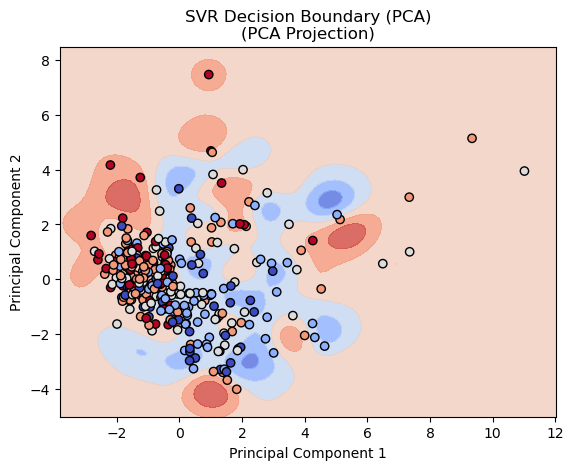

In [16]:
def plot_decision_boundary_pca(model, X, y, title="SVR Decision Boundary (PCA)"):
    """
    Project high-dimensional data to 2D using PCA for visualization
    """
    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Train a new model on PCA-transformed data (for accurate boundary)
    model_pca = SVR(**params_dict)
    model_pca.fit(X_pca, y)
    
    # Plot decision boundary
    display = DecisionBoundaryDisplay.from_estimator(
        model_pca,
        X_pca,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
    )
    
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.title(f"{title}\n(PCA Projection)")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Usage for high-dimensional data
plot_decision_boundary_pca(best_model, X_best, y)

# Run Model and Get Outcomes

In [17]:
# Make predictions
y_pred = best_model.predict(X_test_final)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nFinal Model Evaluation on Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Calculate accuracy within ±1 point
correct = np.sum(np.abs(y_test - y_pred) <= 1)
accuracy = correct / len(y_test)
print(f"Accuracy within ±1 point: {accuracy:.4f}")


Final Model Evaluation on Test Set:
RMSE: 1.2263
R²: 0.0630
Accuracy within ±1 point: 0.5125
